In [2]:
import numpy as np
import pandas as pd
import datetime

In [3]:
# from google.colab import files
# files.upload()

In [4]:
data = pd.read_csv('C:/Users\HAYJAY\PycharmProjects\stage-f-10-police-shootings\data\shootings.csv')
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [5]:
data['race'].unique()

array(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'Native'],
      dtype=object)

In [9]:
data['arms_category'].unique()

array(['Guns', 'Unarmed', 'Other unusual objects', 'Piercing objects',
       'Sharp objects', 'Unknown', 'Blunt instruments', 'Multiple',
       'Electrical devices', 'Hand tools', 'Vehicles', 'Explosives'],
      dtype=object)

In [4]:
data.shape

(4895, 15)

In [5]:
# Converting date to datetime

data['day'] = pd.DatetimeIndex(data['date']).day
data['month'] = pd.DatetimeIndex(data['date']).month
data['year'] = pd.DatetimeIndex(data['date']).year

data.head(2) 

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,day,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns,2,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns,2,1,2015


From the exploratory analysis, a huge percentage of suspects (about 3000), did not flee when they encountered the police. Out of which, some where resistant and chose to attack (as mentioned as one of the threat-level classes), while others might have surrendered (assuming 'undetermined' and 'other' classes in threat-level meant no attack). In the latter case, whether a suspect was armed or not, yet succumbed to an arrest, there is then no logical reason for such individual to be shot.

In line with this, the conditions for the target variable will be used in the next cell, to help classify cases that were justified and unjustified.

In [6]:
def f(row):
  '''
  Function that will be used to create the target column of two classes 1 and 0.
  Where 1 represents the unjustified cases and 0 represents the just ones. 
  '''
    if ((row['threat_level']=='undetermined' or row['threat_level']=='other') and (row['flee']=='Not fleeing')):
        val = 1
    
    else:
        val = 0
    return val

# Applying the function
data['label'] = data.apply(f, axis=1)

In [7]:
data['label'].value_counts()

0    3829
1    1066
Name: label, dtype: int64

In [8]:
# Train and test df
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.15, random_state=100)

In [9]:
# encoding categorical columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['armed','city','state','manner_of_death','gender','race','signs_of_mental_illness',
             'year','threat_level','flee','body_camera','arms_category']
encoder = LabelEncoder()

# Apply label encoder to each column
encoded = data[cat_cols].apply(encoder.fit_transform)

In [10]:
encoded.head(2)

,armed,city,state,manner_of_death,gender,race,signs_of_mental_illness,year,threat_level,flee,body_camera,arms_category
0,35,1889,47,0,1,0,1,0,0,2,0,3
1,35,33,37,0,1,5,0,0,0,2,0,3


In [11]:
# join some important data features with the encoded variables
df = data[['name','date','age','label']].join(encoded)
df.head()  

,name,date,age,label,armed,city,state,manner_of_death,gender,race,signs_of_mental_illness,year,threat_level,flee,body_camera,arms_category
0,Tim Elliot,2015-01-02,53.0,0,35,1889,47,0,1,0,1,0,0,2,0,3
1,Lewis Lee Lembke,2015-01-02,47.0,0,35,33,37,0,1,5,0,0,0,2,0,3
2,John Paul Quintero,2015-01-03,23.0,1,81,2236,16,1,1,2,0,0,1,2,0,9
3,Matthew Hoffman,2015-01-04,32.0,0,80,1826,4,0,1,5,1,0,0,2,0,6
4,Michael Rodriguez,2015-01-04,39.0,0,59,647,5,0,1,2,0,0,0,2,0,7


In [12]:
df_copy = df.copy()

In [13]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     4895 non-null   object 
 1   date                     4895 non-null   object 
 2   age                      4895 non-null   float64
 3   label                    4895 non-null   int64  
 4   armed                    4895 non-null   int64  
 5   city                     4895 non-null   int64  
 6   state                    4895 non-null   int64  
 7   manner_of_death          4895 non-null   int64  
 8   gender                   4895 non-null   int64  
 9   race                     4895 non-null   int64  
 10  signs_of_mental_illness  4895 non-null   int64  
 11  year                     4895 non-null   int64  
 12  threat_level             4895 non-null   int64  
 13  flee                     4895 non-null   int64  
 14  body_camera             

In [14]:
df_copy.shape

(4895, 16)

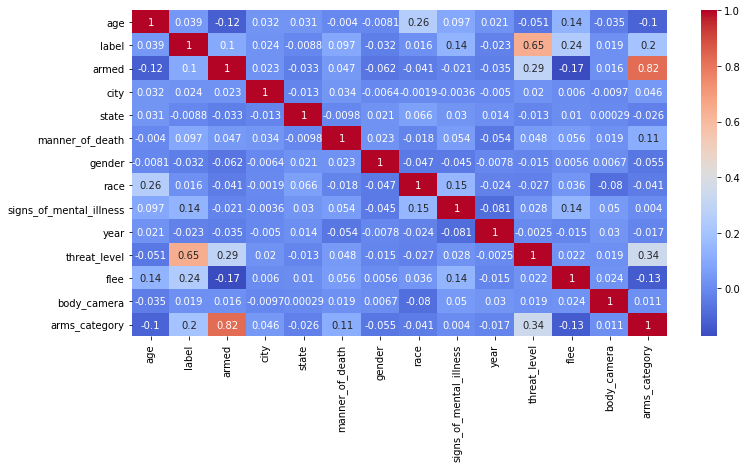

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
corr = df_copy.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

**Model Building**

In [16]:
import warnings
warnings.filterwarnings('ignore') 

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [17]:
train, test = train_test_split(df_copy, test_size=0.15, random_state=100)

In [18]:
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (4160, 16)
test shape: (735, 16)


In [19]:
train = shuffle(train)

In [20]:
train_features = train.drop(columns=['name','date','label'])
train_target = train['label']

test_features = test.drop(columns=['name','date','label'])
test_target = test['label']

In [21]:
train_target.value_counts()

0    3271
1     889
Name: label, dtype: int64

In [22]:
# Oversampling the undersampled labels
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X, y = smote.fit_sample(train_features, train_target)

# converting ndarray to dataframe
X = pd.DataFrame(X, columns=train_features.columns)
y = pd.Series(y, name=train_target.name)

In [23]:
lg = LogisticRegression(random_state=32)
knn = KNeighborsClassifier(n_neighbors=10)
rfc = RandomForestClassifier(random_state=12)

In [24]:
lg.fit(X, y)
knn.fit(X, y)
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [25]:
lg_test_pred = lg.predict_proba(test_features)
knn_test_pred = knn.predict_proba(test_features)
rfc_test_pred = rfc.predict_proba(test_features)

In [26]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_target, lg_test_pred[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(test_target, knn_test_pred[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(test_target, rfc_test_pred[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

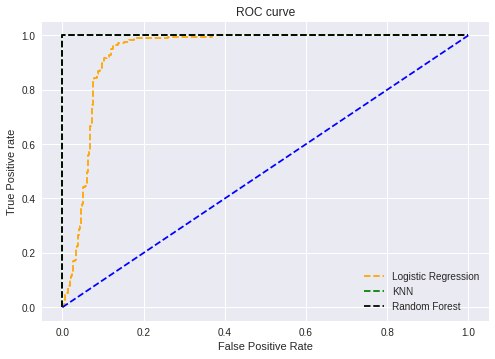

In [27]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(fpr2, tpr2, linestyle='--',color='black', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [28]:
# auc scores
auc_score1 = roc_auc_score(test_target, lg_test_pred[:,1])
auc_score2 = roc_auc_score(test_target, knn_test_pred[:,1])
auc_score3 = roc_auc_score(test_target, rfc_test_pred[:,1])

print(auc_score1, auc_score2, auc_score3)

0.9380151064131381 0.5507006459712858 1.0


The predictive analysis, shows that knn was a very poor model, as it couldn't distinguish both classes clearly, while Random Forest gave a perfect prediction (this is rare, and can likely be attributed to the linearity of the data). On the other hand, Logistic Regression performed just well.

Therefore, the Logistic Regression will be used to predict the suspects who their shootings were unjust.

*The threshold of 0.6 will be used to select the cases of indiscrimate police shootings that needs/needed justice.* 

*0.6 was used because the auc curve shows that the minority/unjust class(1) were almost all correctly classified. Hence the model has no bias, not minding the label is imbalanced.*

In [29]:
pred_result = test_df.copy()
pred_result['label'] = lg_test_pred[:,1]
unjustified_shots = pred_result[pred_result['label']>=0.6]

In [30]:
# Names of suspects whose shots were predicted as unjust, and their dates of occurance
unjustified_shots[['name','date']]

,name,date
2866,Michael Hansford,2018-01-29
2048,Jacob Taulbee,2017-02-26
2230,Jaison Fitzgerald,2017-05-15
731,Matthew Dobbins,2015-10-02
3123,Shukri Ali Said,2018-04-28
...,...,...
108,Daniel Mejia,2015-02-13
52,Demaris Turner,2015-01-23
3257,Robert L. Barton,2018-06-23
1432,Daniel Reyes,2016-06-26


- **Finding Patterns**

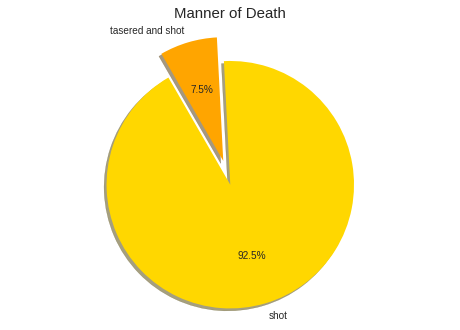

In [31]:
labels = 'shot','tasered and shot'
colors = [ 'gold', 'orange']
explode = (0.1, 0.1)
plt.pie(x=unjustified_shots.groupby("manner_of_death").count()['date'], labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')
plt.title('Manner of Death', size=15)
plt.show()

- Fig 1

In [32]:
import seaborn as sns

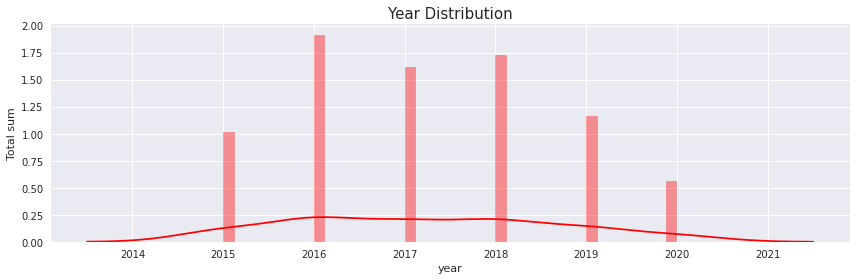

In [33]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
sns.distplot(unjustified_shots['year'], bins=40, color='red')
plt.ylabel('Total sum')
plt.title('Year Distribution', size=15)
plt.tight_layout()

- Fig 2

The rate of unjust shootings was on a growing rate from 2015 - 2018. But from the latter till the present 2020, it's been on a decreasing rate.

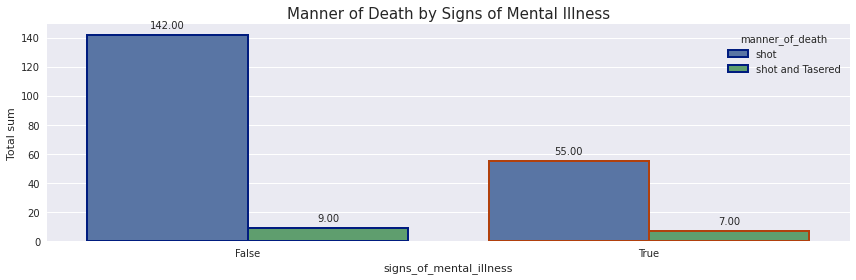

In [34]:
plt.figure(figsize=(12, 4))
splot = sns.countplot(x='signs_of_mental_illness', hue='manner_of_death', linewidth=2, 
                      edgecolor=sns.color_palette("dark", 9), data=unjustified_shots)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha='center', va='center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Total sum')
plt.title('Manner of Death by Signs of Mental Illness', size=15)
plt.tight_layout()

- Fig. 3

In unjust scenerios, the manner of death used by the Police towards suspects is still similar, as it doesn't put into consideration the suspects mental illness.

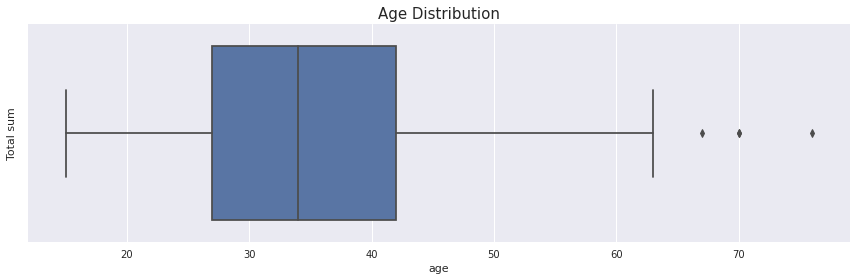

In [35]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
sns.boxplot(unjustified_shots['age'])
plt.ylabel('Total sum')
plt.title('Age Distribution', size=15)
plt.tight_layout()

- Fig. 4

Just as we discovered earlier during the exploratory analysis, the concentrated age bracket is between late 20s to early 40s.

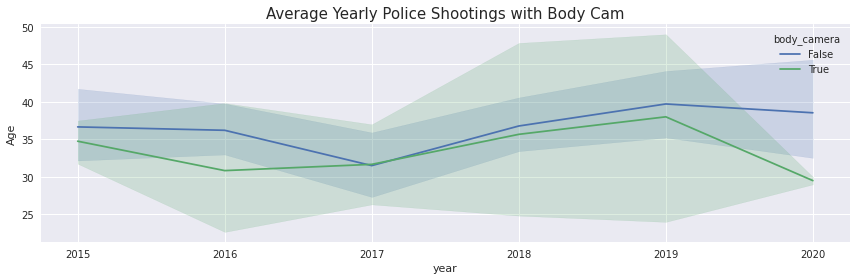

In [36]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
sns.lineplot(x='year',y='age',hue='body_camera', data=unjustified_shots)
plt.ylabel('Age')
plt.title('Average Yearly Police Shootings with Body Cam', size=15)
plt.tight_layout()

- Fig. 5

Not until 2017, there has been a low usage of body cams by Police officers in times like this. But in the more recent years, officers are begining to wear it more often. This could probably tell why unjust shots rate has been on a gradual decrese in recent years too. (as seen in Fig 2)

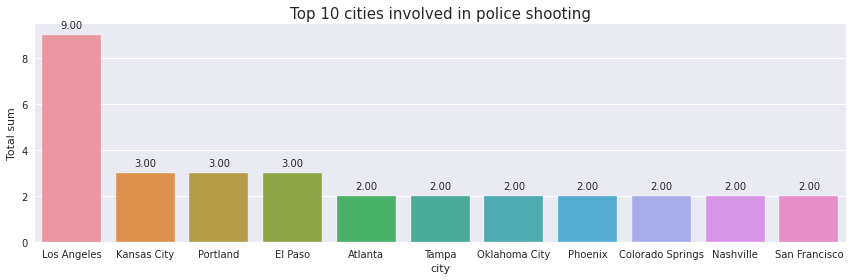

In [37]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
splot = sns.countplot(x='city', order=unjustified_shots.city.value_counts().iloc[:11].index, 
                      data=unjustified_shots)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Total sum')
plt.title('Top 10 cities involved in police shooting', size=15)
plt.tight_layout()


- Fig. 6

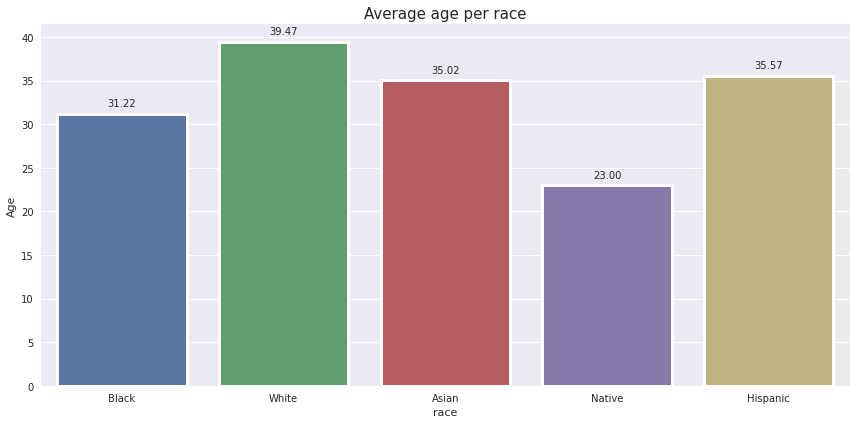

In [38]:
plt.figure(figsize=(12, 6))
splot = sns.barplot(x='race', y='age', linewidth=3, ci=None, data=unjustified_shots)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Age')
plt.title('Average age per race', size=15)
plt.tight_layout()

- Fig. 7

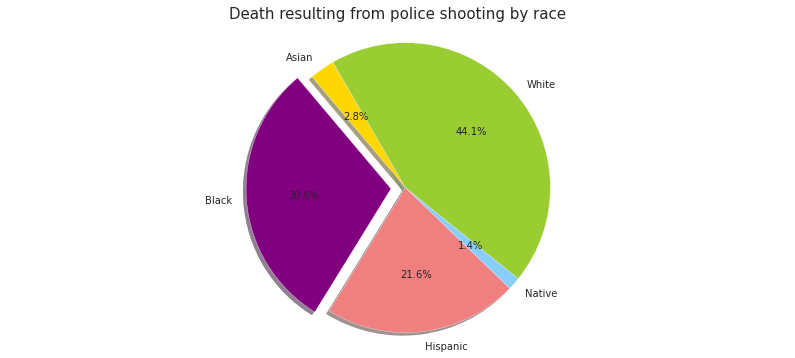

In [39]:
plt.figure(figsize=(14,6))
labels = 'Asian', 'Black','Hispanic','Native','White'
colors = ['gold', 'purple', 'lightcoral', 'lightskyblue', 'yellowgreen']
explode = (0, 0.1, 0, 0, 0)

plt.pie(x=unjustified_shots.groupby("race").count()['manner_of_death'], labels=labels, colors=colors, 
        explode=explode, autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')
plt.title('Death resulting from police shooting by race', size=15)
plt.show()


- Fig. 8

Attributing these cases to race, the pie plot shows that about 44%, 30% and 22% of Whites, Blacks and Hispanics respectively, were shot unjustly. There is an obvious low margin between the percentage of blacks to whites, despite the fact that Whites are more populated considering the data for this analysis is US based.

This can tell that non-whites such as Blacks (mostly) and Hispanics were killed very often by the Police in unjust manners. 